In [1]:
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from model import Model
from sklearn.metrics import roc_auc_score
import itertools
import tqdm
import torch.nn.functional as F

In [2]:
data = HeteroData()
product_df = pd.read_csv("data/processed_product.csv", index_col=0)
user_df = pd.read_csv("./data/processed_user.csv", index_col=0)
purchase_df = pd.read_csv("data/processed_purchase.csv", index_col=0)
product_df = product_df.fillna(product_df.mean())
edge_index_user2product = torch.from_numpy(purchase_df.values[:,:-1].T)

data["user"].node_id = torch.arange(len(user_df))
data["product"].node_id = torch.arange(len(product_df))

/home/piai/miniconda3/envs/cgym/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [3]:
user_df

,ranking,건성,민감성,복합성,약건성,중성,지성,트러블성,가을웜톤,겨울쿨톤,...,민감성.1,블랙헤드,아토피,잡티,주름,탄력,트러블,피지과다,홍조,review
0,0.679428,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,피부가 하도 희안하고 초민감하고 x랄같아서 아무거나.절대못씁니다..전 너무 직업적인...
1,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,사춘기 아이랑 같이 사용해요 물같은 느낌이라 닦토로 무난합니다
2,0.000000,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,항상 잘 사용하는 토너에요! 진정에도 좋고 피부결 정리하는데도 잘 쓰고있어요 화장 ...
3,0.000000,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,아주 좋으네요 저렴하게 잘 샀어요 재구매 예정입니다 품질좋아요
4,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,독도토너로션만 이거까지 3통째쓰는중입니다~~\n피부예민러인데 그만큼 자극없고 좋다는...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,용량도 많고 효과도 좋아요 \n여드름이 심한데 이걸 쓰면 진정효과가 너무 좋아여\n...
3572,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,아들열삼히 사용중입니다. 자극없이 순합니다. 향이 좀 추가되면 좋겠어요
3573,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,몇년째 쓰는 제품!\n바뀐 통 뚜껑이 이전보다 좀 불편하지만 좋아요
3574,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,피부가 예민해서 제가 사용하던 제품인데 남자친구가 사용하고 자기도 이걸로 바꾸고싶다...


In [4]:
def preprocess_user_review(df, method=None, num_review_feat = None):
  df = df.drop('review', axis=1)
  if method == None:
    return df

  else:
    review_df = pd.read_csv('./data/{}.csv'.format(method))
    
    num2uid = pd.read_csv("data/dict_num2uid.csv", index_col=0)
    uid2num = {val:key for key,val in num2uid.to_dict()['0'].items()}
    review_df.iloc[:,0] = review_df.iloc[:,0].apply(lambda x:uid2num[x])
    review_df = review_df.sort_values(by='리뷰자')
    review_df = review_df.drop(['리뷰자'], axis=1)

    if num_review_feat != None:
      pca = PCA(n_components=num_review_feat)
      review_df = pca.fit_transform(review_df)

    df = np.concatenate([df,review_df], axis =1)
    return df

def preprocess_product_pid(df, method=None):
  if method == None:
    return df.drop('pid', axis=1)

In [5]:
# method = None
methods = ['kobart_emb_kobart' ,'kobart_tfidf' ,'kobart_word2vec' ,"lexrank_emb_kobart" ,"lexrank_tfidf" ,"lexrank_word2vec" ,"gpt_emb_kobart" ,"gpt_tfidf" ,"gpt_word2vec"]
num_review_feats = [None, 64, 32, 8]

In [6]:
settings = list(itertools.product(methods,num_review_feats))+[(None,None)]

In [7]:
for method, num_review_feat in settings:
    print(method, num_review_feat, end=' ')
    user_df_processed = preprocess_user_review(user_df, method=method, num_review_feat=num_review_feat)
    product_df_processed = preprocess_product_pid(product_df)

    # user_scaler = MinMaxScaler((0,1))
    # product_scaler = MinMaxScaler((0,1))
    user_scaler = StandardScaler()
    product_scaler = StandardScaler()

    user_scaled = user_scaler.fit_transform(user_df_processed)
    product_scaled = product_scaler.fit_transform(product_df_processed)
    num_user_feat = user_scaled.shape[1]
    num_product_feat = product_scaled.shape[1]
    data["product"].x = torch.from_numpy(product_scaled).to(torch.float)
    data["user"].x = torch.from_numpy(user_scaled).to(torch.float)
    data["user", "purchase", "product"].edge_index = edge_index_user2product
    data["product", "rev_purchase", "user"].edge_index = edge_index_user2product[[1,0]]  # TODO

    transform = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        disjoint_train_ratio=0.3,
        neg_sampling_ratio=2,
        add_negative_train_samples=False,
        edge_types=("user", "purchase", "product"),
        rev_edge_types=("product", "rev_purchase", "user"), 
    )
    test_aucs = []
    for iter in range(10):
        train_data, val_data, test_data = transform(data)
        # Define seed edges:
        edge_label_index = train_data["user", "purchase", "product"].edge_label_index
        edge_label = train_data["user", "purchase", "product"].edge_label

        train_loader = LinkNeighborLoader(
            data=train_data,  # TODO
            num_neighbors=[20,10],  # TODO
            neg_sampling_ratio=2,  # TODO
            edge_label_index=(("user", "purchase", "product"), edge_label_index),
            edge_label=edge_label,
            batch_size=128,
            shuffle=True,
        )

        val_loader = LinkNeighborLoader(
            data=val_data,
            num_neighbors=[20, 10],
            edge_label_index=(("user", "purchase", "product"), edge_label_index),
            edge_label=edge_label,
            batch_size=3 * 128,
            shuffle=False,
        )

                
        ## Training a Heterogeneous Link-level GNN

        model = Model(hidden_channels=64, num_user_feat=num_user_feat, num_product_feat=num_product_feat, data=data)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_losses = []
        for epoch in range(1, 20):
            model = model.train()
            total_loss = total_examples = 0
            val_loss = val_total_examples=  0
            # for sampled_data in tqdm.tqdm(train_loader):
            for sampled_data in train_loader:
                optimizer.zero_grad()
                sampled_data = sampled_data.to(device)
                pred = model(sampled_data)
                ground_truth = sampled_data["user", "purchase", "product"].edge_label
                loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

                # TODO: Move `sampled_data` to the respective `device`
                # TODO: Run `forward` pass of the model
                # TODO: Apply binary cross entropy via
                # `F.binary_cross_entropy_with_logits(pred, ground_truth)`
                # raise NotImplementedError

                loss.backward()
                optimizer.step()
                total_loss += float(loss) * pred.numel()
                total_examples += pred.numel()

            model=model.eval()
            # for sampled_data in tqdm.tqdm(val_loader):
            for sampled_data in val_loader:
                with torch.no_grad():
                    # TODO: Collect predictions and ground-truths and write them into
                    # `preds` and `ground_truths`.
                    # raise NotImplementedError
                    pred = model(sampled_data.to(device))
                    ground_truth = sampled_data["user", "purchase", "product"].edge_label
                    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
                    val_loss += float(loss) * pred.numel()
                    val_total_examples += pred.numel()
            train_loss = total_loss / total_examples
            val_loss = val_loss / val_total_examples
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # print(f"Epoch: {epoch:03d}, Train_Loss: {train_loss:.4f}, Val_Loss: {val_loss:.4f}")
        ## Evaluating a Heterogeneous Link-level GNN

        # Define the validation seed edges:
        edge_label_index = test_data["user", "purchase", "product"].edge_label_index
        edge_label = test_data["user", "purchase", "product"].edge_label

        test_loader = LinkNeighborLoader(
            data=test_data,
            num_neighbors=[20, 10],
            edge_label_index=(("user", "purchase", "product"), edge_label_index),
            edge_label=edge_label,
            batch_size=3 * 128,
            shuffle=False,
        )


        preds = []
        ground_truths = []
        # for sampled_data in tqdm.tqdm(val_loader):
        for sampled_data in test_loader:
            with torch.no_grad():
                # TODO: Collect predictions and ground-truths and write them into
                # `preds` and `ground_truths`.
                # raise NotImplementedError
                pred = model(sampled_data.to(device))
                ground_truth = sampled_data["user", "purchase", "product"].edge_label
                preds.append(pred)
                ground_truths.append(ground_truth)

        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
        auc = roc_auc_score(ground_truth, pred)
        # print(f"Validation AUC: {auc:.4f}")
        test_aucs.append(auc)

    print(sum(test_aucs)/len(test_aucs))

kobart_emb_kobart None 0.8595106956604621
kobart_emb_kobart 64 0.8881719679742922
kobart_emb_kobart 32 0.8853047003717271
kobart_emb_kobart 8 0.891331306763252
kobart_tfidf None 0.7667749451941014
kobart_tfidf 64 0.8841778604594165
kobart_tfidf 32 0.8886386691357687
kobart_tfidf 8 0.890360119007094
kobart_word2vec None 0.8840232295311882
kobart_word2vec 64 0.8851387508340028
kobart_word2vec 32 0.8885300785664685
kobart_word2vec 8 0.8914620239375826
lexrank_emb_kobart None 0.8704039637259839
lexrank_emb_kobart 64 0.889574113914571
lexrank_emb_kobart 32 0.8913839000013617
lexrank_emb_kobart 8 0.8944508176631583
lexrank_tfidf None 0.7832979875001701
lexrank_tfidf 64 0.8881883076210835
lexrank_tfidf 32 0.8826830380849934
lexrank_tfidf 8 0.8903330564670959
lexrank_word2vec None 0.8846489018395719
lexrank_word2vec 64 0.8857111490856605
lexrank_word2vec 32 0.8933620184910336
lexrank_word2vec 8 0.8887981508966382
gpt_emb_kobart None 0.8767507250718264
gpt_emb_kobart 64 0.8894750548058987
gpt_e

In [281]:
%matplotlib inline
import matplotlib.pyplot as plt

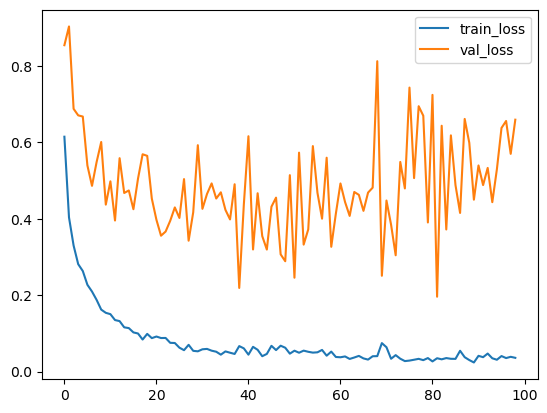

In [282]:
plt.plot(train_losses,label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()